In [533]:
import numpy as np
import sqlite3 as sql
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt


In [534]:
#helper functions
COLORS = {1: "blue", 2: "red", 3: "green"}
    
    
def plot(x, y, title="", xlabel="", ylabel="", ax=None, hist=False, i=None):
    if not ax:
        fig, ax = plt.subplots()
        
    color = COLORS.get(i)
    i = 1 if not i else i
    
    width = (x.iloc[0] - x.iloc[1])/8
    #ax.bar(x.astype(float)+ (i - 1)*width/2, y, width=width, align='center', color=color)
    ax.scatter(x, y, color=color)
    l, = ax.plot(x, y, color=color)
    
    ax.set_xlabel(xlabel if xlabel else x.name)
    ax.set_ylabel(ylabel if ylabel else y.name)
        
    #ax.set_title(title)
    
    ticks_values = ax.get_xticks()
    labels = pd.Series(ticks_values.tolist())
    labels = pd.to_datetime(labels).dt.date.tolist()
    #ax.set_xticks(ticks_values)
    #ax.set_xticklabels(labels, rotation=90)
    ax.set_xticks(x.to_list())
    ax.set_xticklabels(pd.to_datetime(x).dt.date.tolist(), rotation=90)
    
    if title:
        ax.set_title(title)
    #legends
    #plt.show()
    return l


In [535]:
#sqlite> .schema
#CREATE TABLE IF NOT EXISTS "user_groups" (
#        "user_id"       INTEGER,
#        "group_id"      INTEGER,
#        "group_name"    TEXT
#);
#CREATE TABLE IF NOT EXISTS "user_activity" (
#        "report_date_yyyymmdd"  TEXT,
#        "user_id"       INTEGER,
#        "lecture_id"    INTEGER,
#        "watched_seconds"       INTEGER
#);

con = sql.connect('data.sqlite3')
cur = con.cursor()

In [536]:
df_user = pd.read_sql_query("SELECT * FROM user_groups GROUP BY group_id", con)
df_activity = pd.read_sql_query("SELECT report_date_yyyymmdd AS date, user_id, lecture_id FROM user_activity ", con)
df_full = pd.read_sql_query("SELECT T1.report_date_yyyymmdd AS date, T1.user_id, T1.lecture_id, T1.watched_seconds, T2.group_id FROM user_activity T1 JOIN user_groups T2 on T2.user_id == T1.user_id ", con)


df_activity["date"], df_full["date"] = map(lambda x: pd.to_datetime(x["date"]), [df_activity, df_full])
map(lambda x: x.sort_values("date",inplace=True) , [df_activity, df_full])

#convert date to ints
df_activity["date"], df_full["date"] = map(lambda x: pd.to_datetime(x["date"]), [df_activity, df_full])
df_activity["date"], df_full["date"] = map(lambda x: x["date"].astype(np.int64), [df_activity, df_full])

In [537]:
#group by a number of days

def group_by_date(df, start, end, freq):
    """Group by date ranges of frequency 'freq'
    """
    dates = df["date"]
    int_range = pd.date_range(start=start, end=end, freq=freq).astype(np.int64)
    cut = pd.cut(dates, int_range)
    df = df.groupby(cut).agg({"user_id":"count", "lecture_id":"count", "watched_seconds": "sum"})
    return df


def split_groups(df, freq):
    """Split into three groups. all are group_by_date(group, freq)
    """
    get_group = lambda i: df[df["group_id"] == i]
    groups = {i: group_by_date(get_group(i), start=df.date.min(), end=df.date.max(), freq=freq) for i in range(1,4)}
    #print(months
    #months.index = months.index.map(lambda x: x.left)
    def take_left_date(df):
        df["mid_date"] = df.index.map(lambda x: x.mid)
        return df
    
    groups = {i: take_left_date(v) for i, v in groups.items()}
    return groups

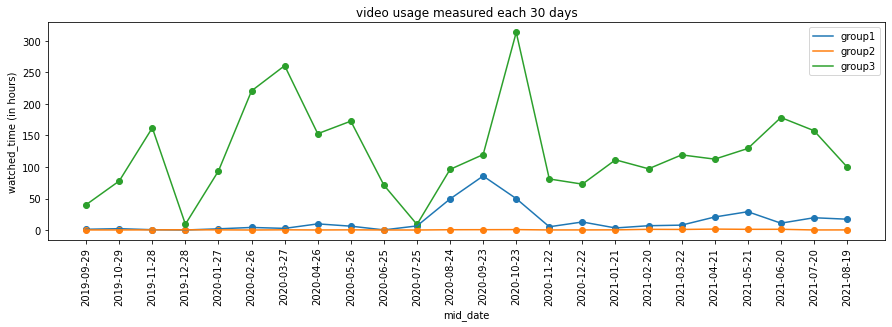

In [538]:
#(1) Video usage change over time
freq = '30D'
groups = split_groups(df_full, freq)
fig, ax = plt.subplots()
fig.set_figwidth(15)
#fig.set_figheight(8)
lines = []
for i in range(1,4):
    g = groups[i]
    l = plot(g.mid_date, g.watched_seconds/(60*60), ylabel="watched_time (in hours)", ax=ax)
    lines.append(l)
    
ax.legend(lines, ("group1", "group2", "group3"))
ax.set_title("video usage")
ax.set_title("video usage measured each {} days".format(freq[:-1]))
fig.savefig("task1.png", dpi=200, bbox_inches="tight")

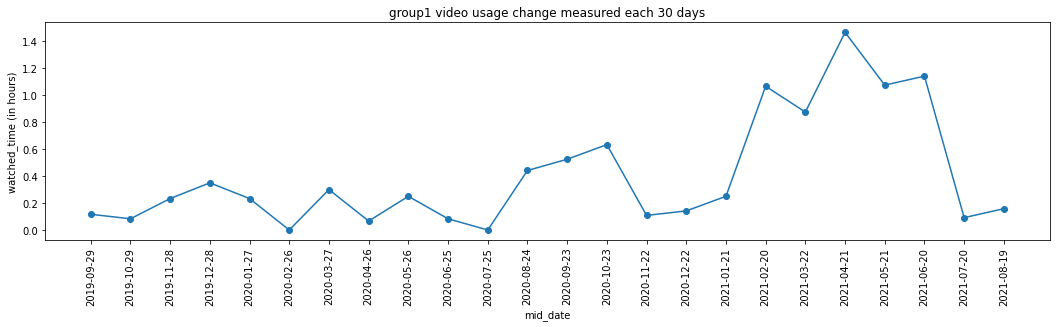

In [539]:
g = groups[2]
title = "group1 video usage change measured each {} days".format(freq[:-1])
fig, ax = plt.subplots()
plot(g.mid_date, g.watched_seconds/(60*60), ylabel="watched_time (in hours)", title=title, ax=ax)
fig.set_figwidth(18)
plt.savefig("task1_group1.png", dpi=200, bbox_inches="tight")

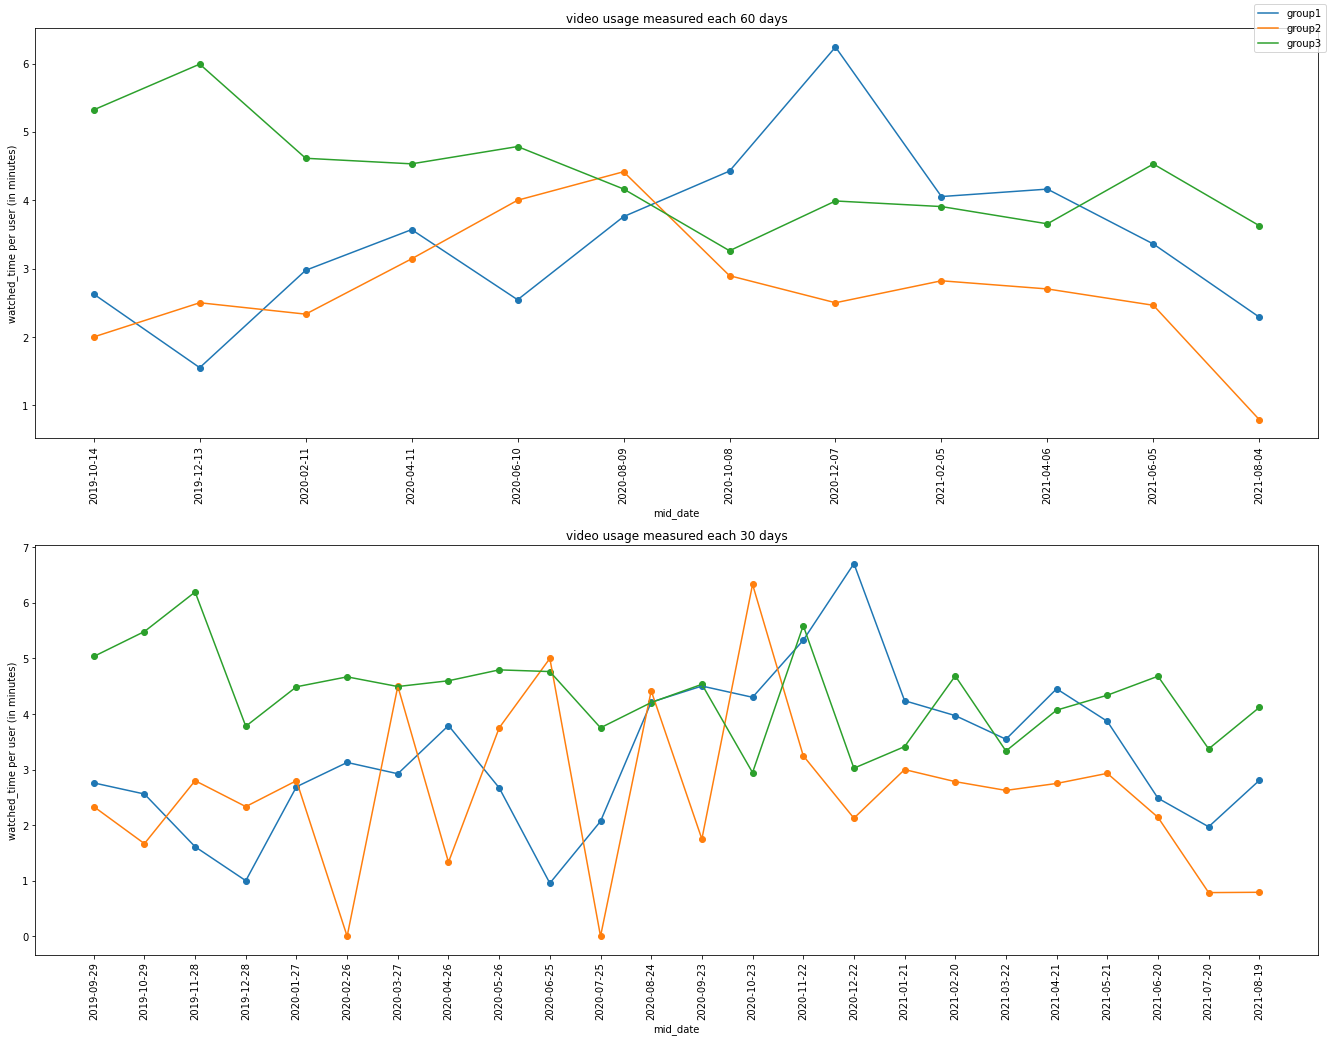

In [540]:
#Task2 
#(2) The video usage of the individual user in the three groups
fig, axes = plt.subplots(2,1)
for j, freq in enumerate(['30D', '60D']):
    groups = split_groups(df_full, freq)
    axes[j-1].set_title("video usage measured each {} days".format(freq[:-1]))
    lines = []
    for i in range(1,4):
        g = groups[i]
        l = plot(g.mid_date, (g.watched_seconds/(60))/(g.user_id+1e-7), ylabel="watched_time per user (in minutes)", ax=axes[j-1])
        lines.append(l)
    
fig.legend(lines, ("group1", "group2", "group3"))
#fig.set_size_inches(18.5, 10.5)
fig.set_figwidth(18.5)
fig.set_figheight(14.5)
fig.tight_layout()
fig.savefig("task2.png", dpi=200, bbox_inches="tight")

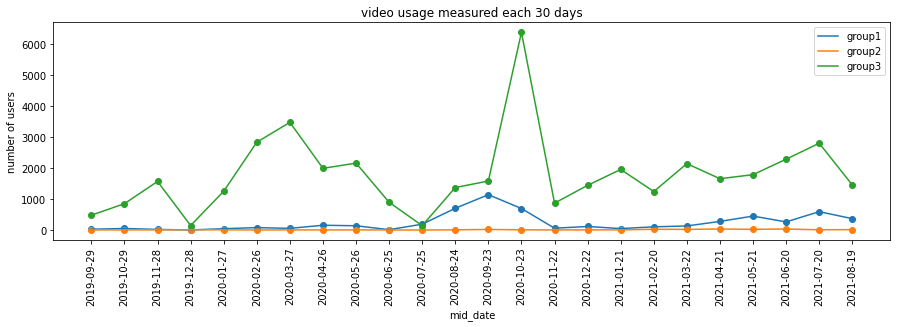

In [541]:
#Number of users for each period (30 days)
#(1) Video usage change over time
freq = '30D'
groups = split_groups(df_full, freq)
fig, ax = plt.subplots()
fig.set_figwidth(15)
#fig.set_figheight(8)
lines = []
for i in range(1,4):
    g = groups[i]
    l = plot(g.mid_date, g.user_id, ylabel="number of users", ax=ax)
    lines.append(l)
    
ax.legend(lines, ("group1", "group2", "group3"))
ax.set_title("video usage")
ax.set_title("video usage measured each {} days".format(freq[:-1]))
fig.savefig("task2_users_count.png", dpi=200, bbox_inches="tight")